### Developing a phylogenetic tree for the used oligonucletide data in this work

This notebook facilitates the implementation of a phylogenetic tree using the processed sequence in this work. For this, the following steps are implemented:

- Read processed sequence in this work
- Make a query to Blast for identifying candidates for a multi alignment sequence process
- Filter candidates based on stablished criteria
- Run a multi alignment sequence
- Process the MSA and prepare data for the development of a phylogenetic tree
- Generate a phylogenetic tree
- Plot phylogenetic tree and save the results

- Process warning

In [148]:
import warnings
warnings.filterwarnings('ignore')

- Load modules

In [ ]:
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import seaborn as sns

- Auxiliar functions

In [150]:
def get_organism(title):
    values = title.split("[")
    organism = values[1].split("]")[0].replace(" ", "-")

    if "beta" in title or "Beta" in title:
        organism = f"{organism}|Beta"
    elif "alpha" in title or "Alpha" in title:
        organism = f"{organism}|Alpha"
    else:
        pass

    return organism

In [151]:
def get_name(title):

    values = title.split("[")
    names = values[0]
    names = names.strip()
    names = names.split("[")
    name_protein = names[0]
    return name_protein

In [224]:
def check_entres_to_ignore(title):

    if "hypothetical" in title: #or "unnamed" in title or "LOW" in title or "partial" in title or "protein" in title or "spatiotemporal" in title:
        return True
    else:
        return False

In [153]:
def translate_nucleotide_sequence(
    nucleotide_seq: str,
    frame: int = +1,
    remove_stop: bool = True,
    id_value: str = ""
) -> SeqRecord:

    seq = Seq(nucleotide_seq)

    if frame < 0:
        seq = seq.reverse_complement()
        offset = abs(frame) - 1
    else:
        offset = frame - 1

    trimmed_seq = seq[offset:]
    trimmed_len = len(trimmed_seq) - (len(trimmed_seq) % 3)
    coding_seq = trimmed_seq[:trimmed_len]

    protein_seq = coding_seq.translate(to_stop=False)

    if remove_stop:
        protein_seq = protein_seq.rstrip("*")

    return SeqRecord(protein_seq, id=id_value, description=f"Frame {frame}")


In [154]:
def fetch_protein_sequence(accession: str, email: str = "david.medina@cebib.cl") -> str:

    try:
        Entrez.email = email

        handle = Entrez.efetch(
            db="protein",
            id=accession,
            rettype="fasta",
            retmode="text"
        )
        record = SeqIO.read(handle, "fasta")
        handle.close()
        return str(record.seq)

    except Exception as e:
        print(f"Error fetching {accession}: {e}")
        return "seq not found"

- Load input sequence

In [155]:
for record in SeqIO.parse("../raw_data/oligos_sequences.fasta", "fasta"):
    sequences_to_process = {
        "Organism" : record.description,
        "Sequence" : str(record.seq)
    }

sequences_to_process

{'Organism': 'Study Argopecten purpuratus',
 'Sequence': 'TCAGTTCAACAGTGTTTGGGCATGAGTCTCTACAATGTACTGGTGGTATTGTTTTAGCAGGTGATGCATTTGTTCTACTTCTTCACTGACTAGTGTTTTCACAAAGAATTTCTTATCCTGAGACATCAACATCCGGGCCCCACTCCGGCCGGGGGAGTCTACATCCAACGCCTGCTTAGTTAAGGAGTTCATATAATCTTGGTCATCGATTCCGAATCTCTCCCGGAGATTCCTGAACACAACTGGGCAATACTCCTTACCTTGAAATGACTTGGCATACTTTCTTTGTTGTAAGAATGATTGTCCACTCGTACTTTACTGAACGCTTTAAAATCATCGGGCATCAACATTACAGGAAGGTTCACATGGTTCAAGCCATTTATCGTATGATTAATCCCCCACCAATGACATCTAGAGAATCACTAGTGAATTCGCGGCCGCCTGCAGGTCGACCATATGGGAGAGCTCCCAACGCGTTGGATGCATA'}

- Making query to NCBI-BLAST for alignment sequences

In [156]:
entrez_query = (
    "(Mollusca[Organism] OR Bivalvia[Organism] OR Cephalopoda[Organism] "
    "OR Mytilus[Organism] OR Crassostrea[Organism] "
    "OR Argopecten[Organism] OR Anadara[Organism] OR Pectinidae[Organism] "
    "OR Veneridae[Organism] OR Mizuhopecten[Organism] "
    "OR Ctenophora[Organism] "
    "OR Brachiopoda[Organism])"
)

In [202]:
query_seq = Seq(sequences_to_process["Sequence"])
record = SeqRecord(query_seq, id="Query1", description=sequences_to_process["Organism"])

print("Sending BLAST query to NCBI...")
result_handle = NCBIWWW.qblast(
    program="blastx",
    database="nr",
    sequence=record.format("fasta"),
    hitlist_size=10000,
    format_type="XML",
    entrez_query=entrez_query
)

blast_records = NCBIXML.read(result_handle)

filter_sequences = []

for alignment in blast_records.alignments:
    hsp = alignment.hsps[0]  # high-scoring pair
    
    filter_sequences.append({
            "Hit_def": alignment.hit_def,
            "Accession": alignment.accession,
            "Length": alignment.length,
            "Frame": hsp.frame[0],  # Solo el marco (ej: +1, -3)
            "E_value": hsp.expect,
            "Score": hsp.score,
            "Identities": hsp.identities,
            "Align_length": hsp.align_length,
            "Percent_identity": round((hsp.identities / hsp.align_length) * 100, 2)
        })

df_selected_sequences = pd.DataFrame(
    data=filter_sequences)

print(df_selected_sequences.shape)
df_selected_sequences.head(5)


Sending BLAST query to NCBI...
(134, 9)


,Hit_def,Accession,Length,Frame,E_value,Score,Identities,Align_length,Percent_identity
0,phosphatidylinositol 5-phosphate 4-kinase type...,XP_069111413,407,-2,5.917040e-70,456.0,85,87,97.70
1,phosphatidylinositol 5-phosphate 4-kinase type...,XP_033762842,407,-2,9.109530e-70,456.0,85,87,97.70
2,phosphatidylinositol 5-phosphate 4-kinase type...,XP_060083998,407,-2,1.628360e-69,454.0,84,87,96.55
3,phosphatidylinositol 5-phosphate 4-kinase type...,XP_021377781,407,-2,1.697330e-69,453.0,84,87,96.55
4,phosphatidylinositol 5-phosphate 4-kinase type...,XP_060589942,410,-2,6.442520e-59,406.0,73,87,83.91


In [158]:
df_selected_sequences.to_csv("tmp.csv", index=False)

In [159]:
df_selected_sequences.shape

(134, 9)

- Get name, ID, and organism

In [203]:
df_selected_sequences["organism"] = df_selected_sequences["Hit_def"].apply(get_organism)
df_selected_sequences["protein_name"] = df_selected_sequences["Hit_def"].apply(get_name)

In [161]:
df_selected_sequences.head(5)

,Hit_def,Accession,Length,Frame,E_value,Score,Identities,Align_length,Percent_identity,organism,protein_name
0,phosphatidylinositol 5-phosphate 4-kinase type...,XP_069111413,407,-2,5.917040e-70,456.0,85,87,97.70,Argopecten-irradians|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...
1,phosphatidylinositol 5-phosphate 4-kinase type...,XP_033762842,407,-2,9.109530e-70,456.0,85,87,97.70,Pecten-maximus|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...
2,phosphatidylinositol 5-phosphate 4-kinase type...,XP_060083998,407,-2,1.628360e-69,454.0,84,87,96.55,Ylistrum-balloti|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...
3,phosphatidylinositol 5-phosphate 4-kinase type...,XP_021377781,407,-2,1.697330e-69,453.0,84,87,96.55,Mizuhopecten-yessoensis|Beta,phosphatidylinositol 5-phosphate 4-kinase type...
4,phosphatidylinositol 5-phosphate 4-kinase type...,XP_060589942,410,-2,6.442520e-59,406.0,73,87,83.91,Ruditapes-philippinarum|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...


In [204]:
df_selected_sequences.shape

(134, 11)

- Removing PREDICTED/Uncultured elements

In [163]:
df_selected_sequences["to_ignore"] = df_selected_sequences["Hit_def"].apply(check_entres_to_ignore)
df_selected_sequences["to_ignore"].value_counts()
df_selected_sequences = df_selected_sequences[df_selected_sequences["to_ignore"]==False]
print(df_selected_sequences.shape)
df_selected_sequences.head(5)

(95, 12)


,Hit_def,Accession,Length,Frame,E_value,Score,Identities,Align_length,Percent_identity,organism,protein_name,to_ignore
1,phosphatidylinositol 5-phosphate 4-kinase type...,XP_033762842,407,-2,9.109530e-70,456.0,85,87,97.70,Pecten-maximus|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...,False
2,phosphatidylinositol 5-phosphate 4-kinase type...,XP_060083998,407,-2,1.628360e-69,454.0,84,87,96.55,Ylistrum-balloti|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...,False
3,phosphatidylinositol 5-phosphate 4-kinase type...,XP_021377781,407,-2,1.697330e-69,453.0,84,87,96.55,Mizuhopecten-yessoensis|Beta,phosphatidylinositol 5-phosphate 4-kinase type...,False
4,phosphatidylinositol 5-phosphate 4-kinase type...,XP_060589942,410,-2,6.442520e-59,406.0,73,87,83.91,Ruditapes-philippinarum|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...,False
5,phosphatidylinositol 5-phosphate 4-kinase type...,XP_064613695,433,-2,6.656470e-59,393.0,72,87,82.76,Liolophura-japonica|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...,False


In [205]:
df_selected_sequences["organism"].value_counts().head(6)

Ostrea-edulis                  9
Bolinopsis-microptera|Alpha    9
Magallana-gigas                8
Mya-arenaria                   6
Magallana-angulata             6
Dreissena-polymorpha           6
Name: organism, dtype: int64

- Checking duplicated entries. Including organisms and sequences

In [206]:
organism_count = df_selected_sequences.groupby(by="organism").count().sort_values(by="Hit_def", ascending=False)
unique_organism = organism_count[organism_count["Hit_def"]==1]
duplicated_organism = organism_count[organism_count["Hit_def"]>1]

print(unique_organism.shape, duplicated_organism.shape)

(45, 10) (23, 10)


In [207]:
filter_unique_organism = df_selected_sequences[df_selected_sequences["organism"].isin(unique_organism.index)]
filter_unique_organism.shape

(45, 11)

In [208]:
filter_unique_organism.columns

Index(['Hit_def', 'Accession', 'Length', 'Frame', 'E_value', 'Score',
       'Identities', 'Align_length', 'Percent_identity', 'organism',
       'protein_name'],
      dtype='object')

In [210]:
matrix_duplicated = []
for organism in duplicated_organism.index:
    records_in_df = df_selected_sequences[df_selected_sequences["organism"] == organism]
    records_in_df.reset_index(inplace=True)
        
    row = []

    for column in ['Hit_def', 'Accession', 'Length', 'Frame', 'E_value', 'Score',
       'Identities', 'Align_length', 'Percent_identity', 'organism',
       'protein_name']:
        row.append(records_in_df[column][0])
    
    matrix_duplicated.append(row)

df_selected_duplicated = pd.DataFrame(data=matrix_duplicated, columns=filter_unique_organism.columns)
df_selected_duplicated.head(5)

,Hit_def,Accession,Length,Frame,E_value,Score,Identities,Align_length,Percent_identity,organism,protein_name
0,1-phosphatidylinositol 3-phosphate 5-kinase-li...,XP_055998373,2077,-2,1.587310e+00,79.0,25,87,28.74,Ostrea-edulis,1-phosphatidylinositol 3-phosphate 5-kinase-li...
1,phosphatidylinositol 5-phosphate 4-kinase type...,XP_063681229,389,-2,8.840280e-22,181.0,39,93,41.94,Bolinopsis-microptera|Alpha,phosphatidylinositol 5-phosphate 4-kinase type...
2,1-phosphatidylinositol 3-phosphate 5-kinase is...,XP_034323711,2143,-2,1.986730e+00,79.0,25,80,31.25,Magallana-gigas,1-phosphatidylinositol 3-phosphate 5-kinase is...
3,"PI42B-like protein, partial [Mya arenaria]",WAQ93696,286,-2,4.072420e-26,262.0,48,61,78.69,Mya-arenaria,"PI42B-like protein, partial"
4,1-phosphatidylinositol 3-phosphate 5-kinase-li...,XP_052697493,2118,-2,2.139150e+00,78.0,25,86,29.07,Magallana-angulata,1-phosphatidylinositol 3-phosphate 5-kinase-li...


In [211]:
processed_df = pd.concat([filter_unique_organism, df_selected_duplicated], axis=0)
processed_df.reset_index(inplace=True)
processed_df = processed_df.drop(columns=["index"])
processed_df.shape

(68, 11)

- Check identity

In [212]:
processed_df["Percent_identity"].describe()

count    68.000000
mean     73.150441
std      17.940365
min      28.740000
25%      73.572500
50%      79.000000
75%      82.055000
max      97.700000
Name: Percent_identity, dtype: float64

<Axes: xlabel='Percent_identity', ylabel='Count'>

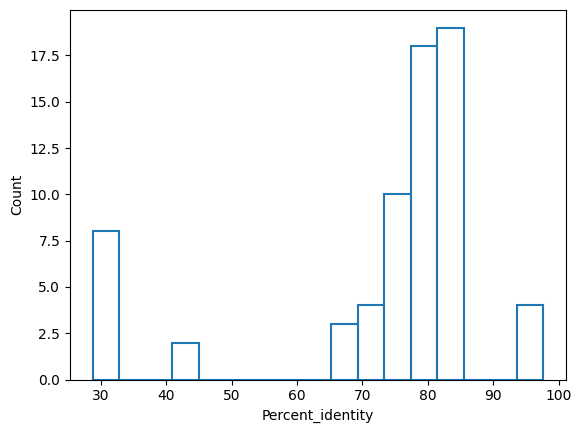

In [213]:
sns.histplot(data=processed_df, x="Percent_identity", fill=False)

In [215]:
processed_df = processed_df[processed_df["Percent_identity"]>70]
processed_df.shape

(54, 11)

- Get full sequences

In [216]:
processed_df["full_sequence"] = processed_df["Accession"].apply(fetch_protein_sequence)

In [217]:
processed_df = processed_df[processed_df["full_sequence"] != "seq not found"]
processed_df.shape

(54, 12)

- Checking length

In [218]:
processed_df["length"] = processed_df["full_sequence"].str.len()
processed_df["length"].describe()

count     54.000000
mean     378.888889
std       65.986753
min       55.000000
25%      370.500000
50%      407.000000
75%      410.750000
max      439.000000
Name: length, dtype: float64

- Prepare a fasta file for generating the MSA

In [241]:
translated = translate_nucleotide_sequence(sequences_to_process["Sequence"], frame=-3, id_value="Studied-Argopecten purpuratus")
print(translated.seq)

CIQRVGSSPIWSTCRRPRIH**FSRCHWWGINHTINGLNHVNLPVMLMPDDFKAFSKVRVDNHSYNKESMPSHFKVRSIAQLCSGISGRDSESMTKII*TP*LSRRWM*TPPAGVGPGC*CLRIRNSL*KH*SVKK*NKCITC*NNTTSTL*RLMPKHC*T


In [242]:
fasta_file = "tmp.fasta"
records = [
    SeqRecord(Seq(seq), id=seq_id, description="")
    for seq_id, seq in zip(processed_df["organism"], processed_df["full_sequence"])
]

records.append(translated)

SeqIO.write(records, fasta_file, "fasta")

55

- Runing MSA

In [243]:
aligned_file = "aligned_sequences.fasta"
clustalomega_cline = ClustalOmegaCommandline(
    infile=fasta_file, outfile=aligned_file, verbose=True, auto=True, force=True
)
print("Running alignment...")
stdout, stderr = clustalomega_cline()

Running alignment...


- Read alignment and estimate distances and Ploting

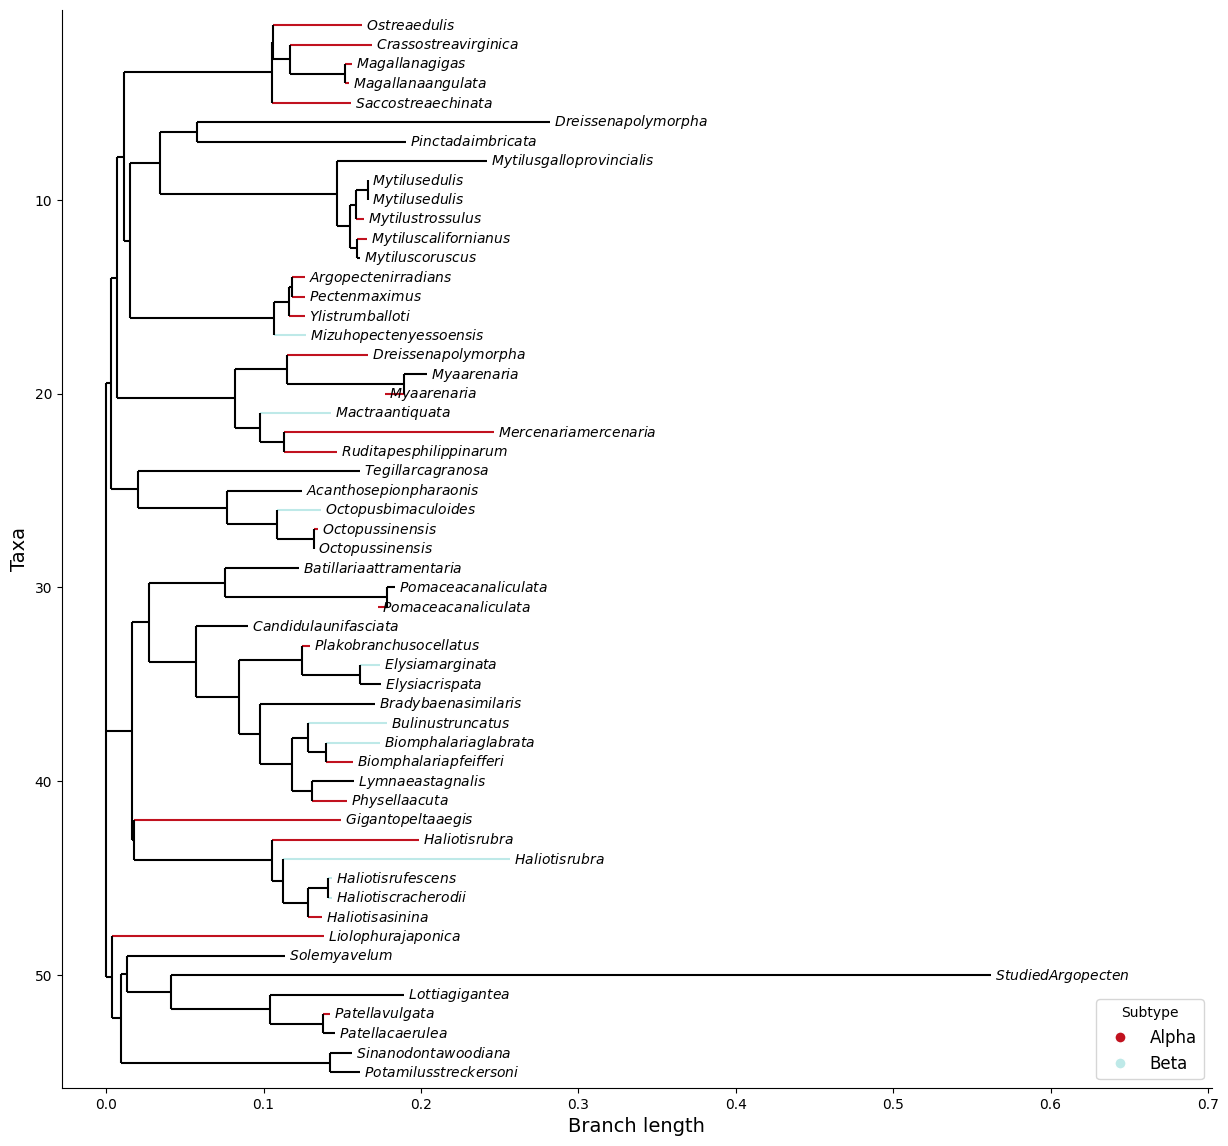

In [244]:
alignment = AlignIO.read(aligned_file, "fasta")
calculator = DistanceCalculator("blosum62")
constructor = DistanceTreeConstructor()

dm = calculator.get_distance(alignment)
tree = constructor.nj(dm)

for clade in tree.find_clades():
    if clade.name:
        if clade.name.startswith("Inner"):
            clade.name = ""
        else:
            parts = clade.name.split("|")
            raw_name = parts[0]
            subtype = parts[1].lower() if len(parts) > 1 else ""

            formatted_name = raw_name.replace("-", "   ").strip()
            formatted_name = f"$\\it{{{formatted_name}}}$"
            clade.name = formatted_name

            if subtype == "alpha":
                clade.color = "#c1121f"
            elif subtype == "beta":
                clade.color = "#bee9e8"

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, do_show=False, axes=ax, show_confidence=True)

plt.subplots_adjust(right=0.7)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Alpha', markerfacecolor="#c1121f", markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Beta', markerfacecolor="#bee9e8", markersize=8)
]

ax.set_xlabel("Branch length", fontsize=14)
ax.set_ylabel("Taxa", fontsize=14)

ax.legend(handles=legend_elements, loc='lower right', title="Subtype", fontsize=12)

sns.despine()
#plt.tight_layout()
plt.show()